In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data.csv
./model_data.csv
./Project_2.ipynb
./raw_data.csv
./zipCodeToLatLong.csv
./.ipynb_checkpoints/data-checkpoint.csv
./.ipynb_checkpoints/Project_2-checkpoint.ipynb
./.ipynb_checkpoints/model_data-checkpoint.csv
./.ipynb_checkpoints/raw_data-checkpoint.csv
./.ipynb_checkpoints/zipCodeToLatLong-checkpoint.csv
./models/base_gbr_model.pkl
./ScrapingChicago/raw_data_sold.csv
./ScrapingChicago/package.log
./ScrapingChicago/HomeHarvest_20250910_003045.csv
./ScrapingChicago/.gitignore
./ScrapingChicago/data.csv
./ScrapingChicago/raw_data.csv
./ScrapingChicago/scraper.ipynb
./ScrapingChicago/.ipynb_checkpoints/data-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/scraper-checkpoint.ipynb
./ScrapingChicago/.ipynb_checkpoints/HomeHarvest_20250910_003045-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/raw_data-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/raw_data_sold-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/df-checkpoint.csv


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Market prices are an important thing to consider when buying a house. This ML project aims to predict the price a house will be sold at given certain attributes. We must use data from public real estate websites and then build a property selling price predictor for a city, which is, in my case, Chicago. 

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

I used the Python Library HomeHarvest, which scrapes data from Realtors.com, Zillow, and Redfin. I used it to scrap for any homes sold, pending, or for sale in Chicago. Then, I saved the data as a csv. 

In [2]:
from homeharvest import scrape_property
from datetime import datetime

In [3]:
# current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# filename = f"HomeHarvest_{current_timestamp}.csv"

# sold_properties = scrape_property(
#     location="Chicago, IL",
#     listing_type="sold",
#     past_days=730,
# )
# print(f"Number of sold properties: {len(sold_properties)}")
# print(sold_properties.head())

In [4]:
# pending_properties = scrape_property(
#     location="Chicago, IL",
#     listing_type="pending",
#     past_days=730,
# )
# print(f"Number of pending properties: {len(pending_properties)}")
# print(pending_properties.head())

In [5]:
# for_sale_properties = scrape_property(
#     location="Chicago, IL",
#     listing_type="for_sale",
#     past_days=730,
# )
# print(f"Number of for sale properties: {len(for_sale_properties)}")
# print(for_sale_properties.head())

In [236]:
import pandas as pd

In [237]:
# df = pd.concat([sold_properties, pending_properties, for_sale_properties])
# print(len(df))

In [238]:
# df.to_csv("raw_data.csv", index=False)

In [347]:
df = pd.read_csv("raw_data.csv")

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

In [348]:
df = df[["property_id", "formatted_address", "zip_code", "style", "beds", 
                           "full_baths", "half_baths", "sqft", "year_built", 
                           "list_price", "sold_price", "latitude", "longitude", "stories", "days_on_mls"]]

df = df.dropna(subset=['zip_code', "list_price", "sold_price", "sqft", "beds", "full_baths"])
print(len(df))

df.drop_duplicates(inplace=True)
print(len(df))

10526
10432


In [349]:
df.to_csv("data.csv", index=False)

I've taken the dataset and some of the columns I've estimated will have the greatest value in this predictor. After dropping the nan values within a few important columns, my dataset is down to 10,383. After dropping all the duplicate values, I'm down to 8779 properties. This is a signifcant decrease from my original count of 22,719. 

A few of the columns I got are less important and will NOT be used for training, just identification purposes, like formatting address and property id. Zip code and style will need to be one-hot-encoded since they are categorical variables, and I'll combined full and half baths into a single baths column. 

In [350]:
import matplotlib.pyplot as plt

In [351]:
df["age"] = datetime.now().year - df["year_built"]
df.drop(columns="year_built", inplace=True)

In [352]:
def outlier_calc(data, val):
    q3 = data[f"{val}"].quantile(0.75)
    q1 = data[f"{val}"].quantile(0.25)
    iqr = q3 - q1
    print(f"outlier bounds: {q1 - 1.5 * iqr} to {q3 + 1.5 * iqr}")

    data = data[((q1 - 1.5 * iqr) <= data[f"{val}"]) & (data[f"{val}"] <= (q3 + 1.5 * iqr))]
    return data

In [353]:
# predicting sold price
print(df.info())
df_price = outlier_calc(df, "sold_price")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10432 entries, 0 to 23082
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   property_id        10432 non-null  int64  
 1   formatted_address  10432 non-null  object 
 2   zip_code           10432 non-null  int64  
 3   style              10432 non-null  object 
 4   beds               10432 non-null  float64
 5   full_baths         10432 non-null  float64
 6   half_baths         2880 non-null   float64
 7   sqft               10432 non-null  float64
 8   list_price         10432 non-null  float64
 9   sold_price         10432 non-null  float64
 10  latitude           10390 non-null  float64
 11  longitude          10390 non-null  float64
 12  stories            6081 non-null   float64
 13  days_on_mls        10293 non-null  float64
 14  age                9680 non-null   float64
dtypes: float64(11), int64(2), object(2)
memory usage: 1.3+ MB
None
outlier boun

Calculating statistical outlier bounds gives us a sold price outlier of 0 - around 2 million. This is a very large range and is most likely due to Chicago's diverse housing market.

In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10432 entries, 0 to 23082
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   property_id        10432 non-null  int64  
 1   formatted_address  10432 non-null  object 
 2   zip_code           10432 non-null  int64  
 3   style              10432 non-null  object 
 4   beds               10432 non-null  float64
 5   full_baths         10432 non-null  float64
 6   half_baths         2880 non-null   float64
 7   sqft               10432 non-null  float64
 8   list_price         10432 non-null  float64
 9   sold_price         10432 non-null  float64
 10  latitude           10390 non-null  float64
 11  longitude          10390 non-null  float64
 12  stories            6081 non-null   float64
 13  days_on_mls        10293 non-null  float64
 14  age                9680 non-null   float64
dtypes: float64(11), int64(2), object(2)
memory usage: 1.3+ MB


In [355]:
# convert to numbers

cols = df.columns.difference(['formatted_address', 'style'])
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

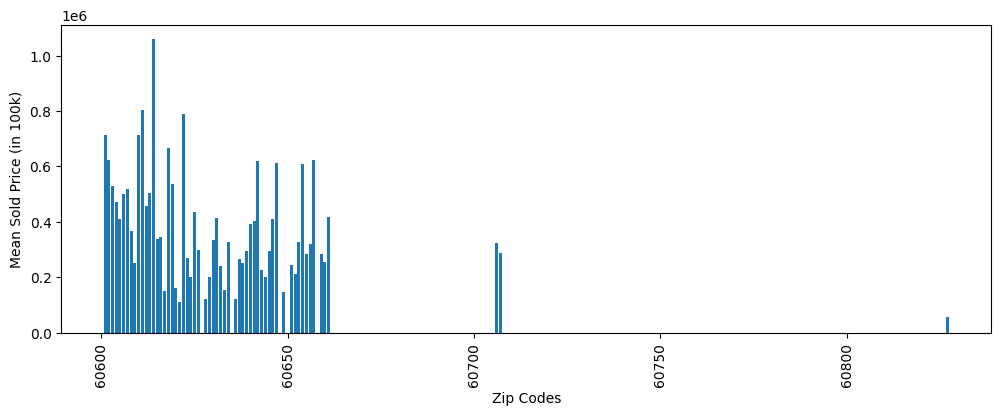

In [356]:
# zip_code vs. price
# would indicate richer zip codes

plt.figure(figsize=(12, 4))

grouped_data = df.groupby("zip_code", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["zip_code"], grouped_data["sold_price"])

plt.xticks(rotation=90)
plt.xlabel("Zip Codes")
plt.ylabel("Mean Sold Price (in 100k)")
plt.show()

The zipcodes need to be encoded.
The highest mean selling price has a zipcode of 60614, and the lowest is 60827. 

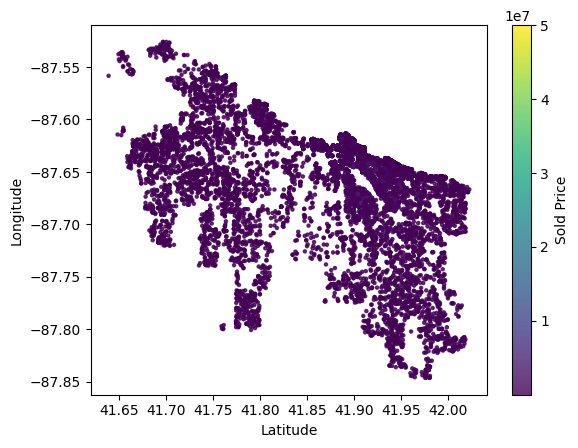

In [357]:
plt.scatter(df["latitude"], df["longitude"], c=df["sold_price"], cmap='viridis', s=5, alpha=0.8)
plt.colorbar(label='Sold Price')

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

This map traces out the shape of Chicago with all of the properties mapped using price as color. It's clear the majority of properties are just less or around 10^7 dollars. This may be a better alternative than using the zipcodes, although the numbers may vary a lot compared to using the zipcodes to "bin" the coordinates.

In [358]:
# lat and long for zip

lat_long_df = pd.read_csv("zipCodeToLatLong.csv")

df.rename(columns={"latitude": "zip_lat", "longitude": "zip_long"}, inplace=True)
df['zip_code'] = df['zip_code'].astype(int)
df = df.merge(lat_long_df, left_on="zip_code", right_on="zip", how="left")

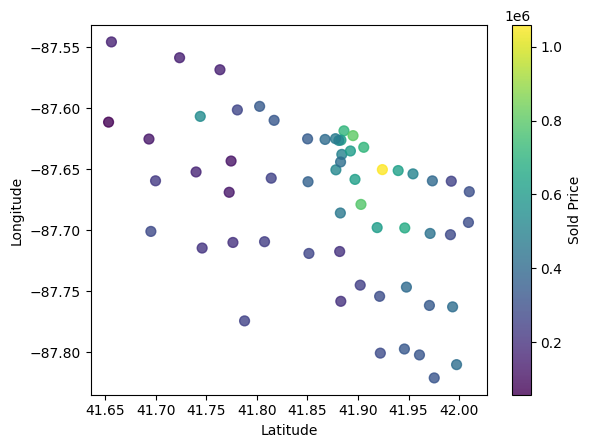

In [359]:
grouped_data = df.groupby("zip_code", as_index=False)[["sold_price", "zip_lat", "zip_long"]].mean()

plt.scatter(grouped_data["zip_lat"], grouped_data["zip_long"], c=grouped_data["sold_price"], cmap='viridis', s=50, alpha=0.8)
plt.colorbar(label='Sold Price')

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Grouping the data by zipcode gives us a clearer picture of where the richer areas of Chicago are (downtown). I still might use the raw latitudes and longitudes because they're more precise than this binning. 

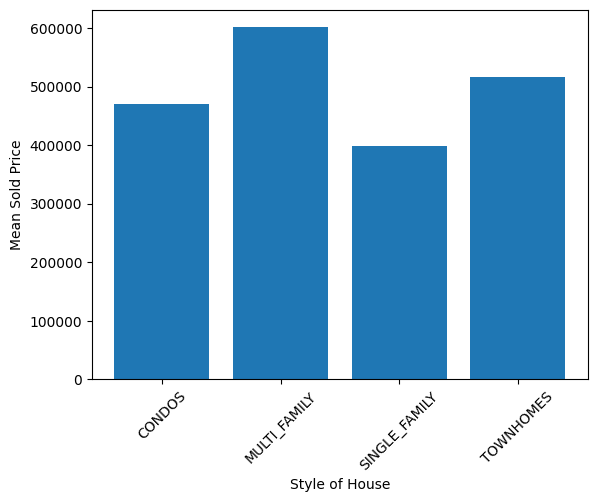

In [360]:
# style vs. price
# larger homes, pricier

grouped_data = df.groupby("style", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["style"], grouped_data["sold_price"])

plt.xticks(rotation=45)
plt.xlabel("Style of House")
plt.ylabel("Mean Sold Price")
plt.show()

The trends seem to make sense, with houses being higher than condos or single family houses. However, this metric might just be easier to figure out using the number of beds and baths. For now, if I choose to use this, label encoding should work just fine since these can somewhat be predicted by their size. 

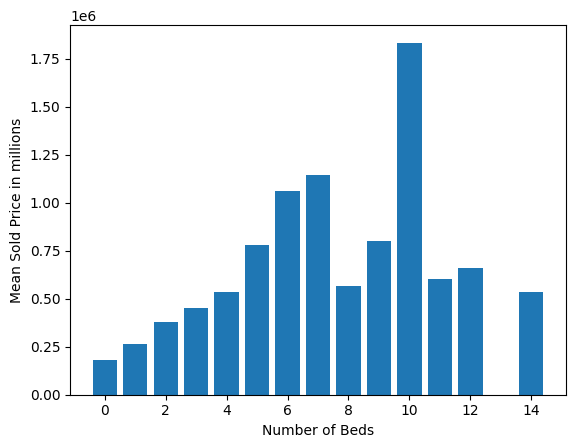

In [361]:
# beds vs. price
# more beds, higher price

grouped_data = df.groupby("beds", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["beds"], grouped_data["sold_price"])

plt.xlabel("Number of Beds")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: 0.5 to 4.5


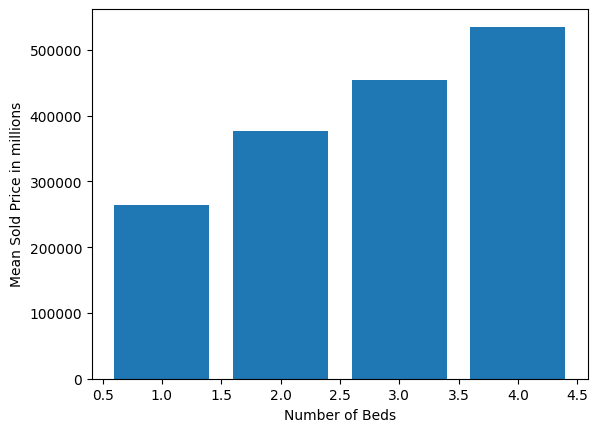

In [362]:
df_beds = outlier_calc(df, "beds")

grouped_data = df_beds.groupby("beds", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["beds"], grouped_data["sold_price"])

plt.xlabel("Number of Beds")
plt.ylabel("Mean Sold Price in millions")
plt.show()

The sold price does increase and act as intended until about 7 rooms, and then it starts to go a little weird. 10 rooms has the maximum mean sold price, but 8, 11, and 14, which are all supposed to be high according to the trend, are very low, about the same price as the 5 room properties.

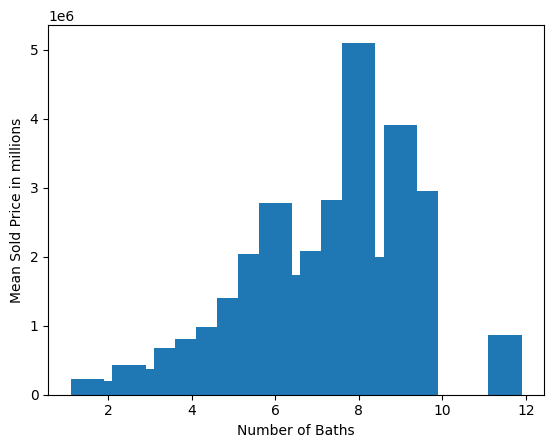

In [363]:
# baths vs. price
# more baths, higher price

df["baths"] = df["full_baths"] + 0.5 * df["half_baths"].bfill()

grouped_data = df.groupby("baths", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["baths"], grouped_data["sold_price"])

plt.xlabel("Number of Baths")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: 0.0 to 4.0


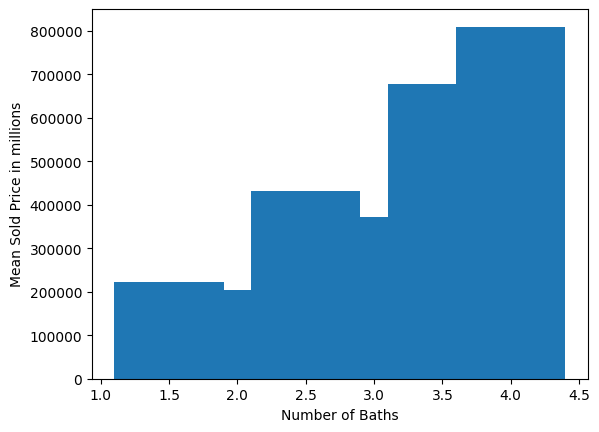

In [364]:
df_baths = outlier_calc(df, "baths")

grouped_data = df_baths.groupby("baths", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["baths"], grouped_data["sold_price"])

plt.xlabel("Number of Baths")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute does mostly follow the trend of increases rooms with increasing prices. It has a peak at around 8 baths. 

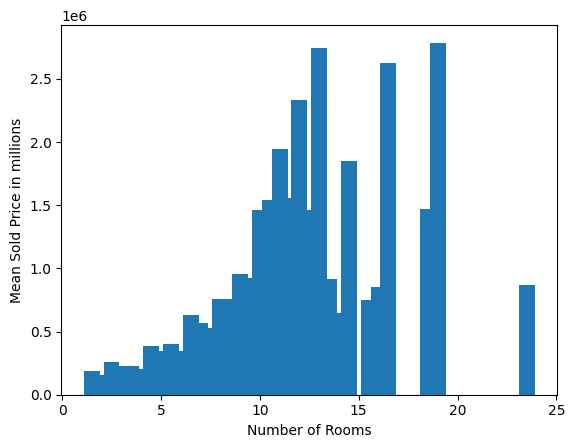

In [365]:
# combined bath + beds vs. sold price
# more rooms, higher price

df["numOfRooms"] = (df["baths"] + df["beds"]).bfill()

df["numOfRooms"] = df["numOfRooms"].replace(0, 1)

grouped_data = df.groupby("numOfRooms", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["numOfRooms"], grouped_data["sold_price"])

plt.xlabel("Number of Rooms")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: 1.5 to 9.5


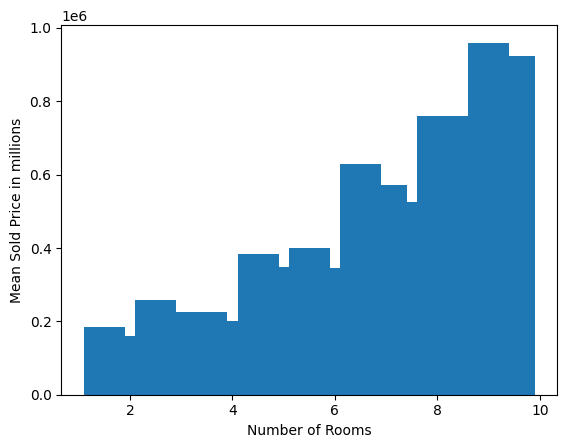

In [366]:
df_numOfRooms = outlier_calc(df, "numOfRooms")

grouped_data = df_numOfRooms.groupby("numOfRooms", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["numOfRooms"], grouped_data["sold_price"])

plt.xlabel("Number of Rooms")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This seems to follow the trend, but there are some odd lower values at some points, like at 16 and 24 rooms. Not sure why the trend doesn't apply at this higher room counts.

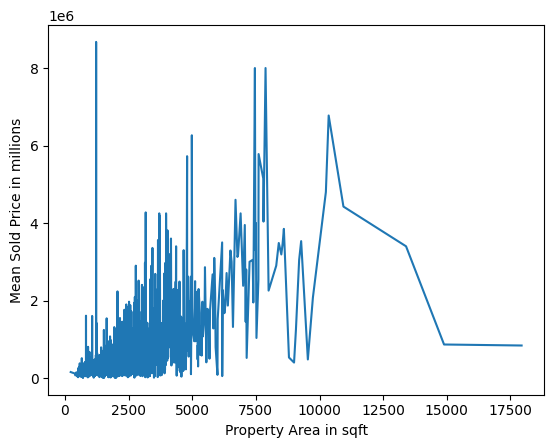

In [367]:
# sqft vs. sold price
# bigger house, higher price

grouped_data = df.groupby("sqft", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["sqft"], grouped_data["sold_price"])

plt.xlabel("Property Area in sqft")
plt.ylabel("Mean Sold Price in millions")
plt.show()

outlier bounds: -375.0 to 3425.0


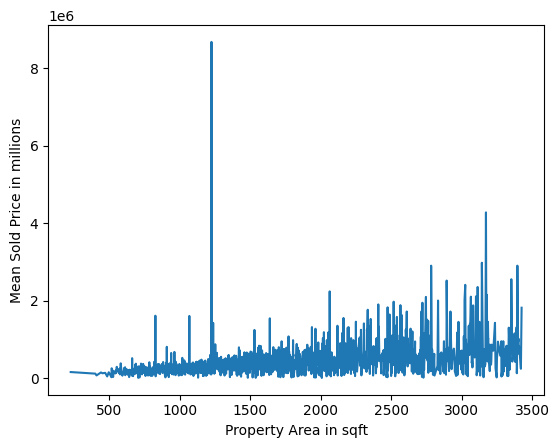

In [368]:
df_sqft = outlier_calc(df, "sqft")

grouped_data = df_sqft.groupby("sqft", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["sqft"], grouped_data["sold_price"])

plt.xlabel("Property Area in sqft")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute follows the trend as predicted. There are outliers for the properties with 15000 sqft which goes down, so it's a similar phenomenon as the bath and bed room issue of going down at extremely high values.

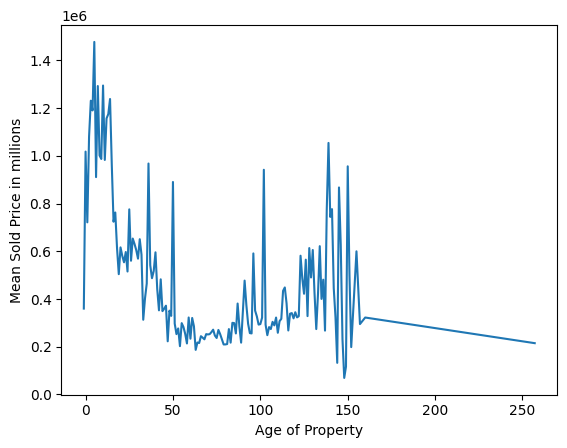

In [369]:
# age vs. sold price
# newer houses, higher price

grouped_data = df.groupby("age", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["age"], grouped_data["sold_price"])

plt.xlabel("Age of Property")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute has a lot of variation in the trend. The price is higher if the property is new, as expected, but it also seems to peak around 150 years in age, which might be able to be attributed to larger properties being older like historical buildings. 

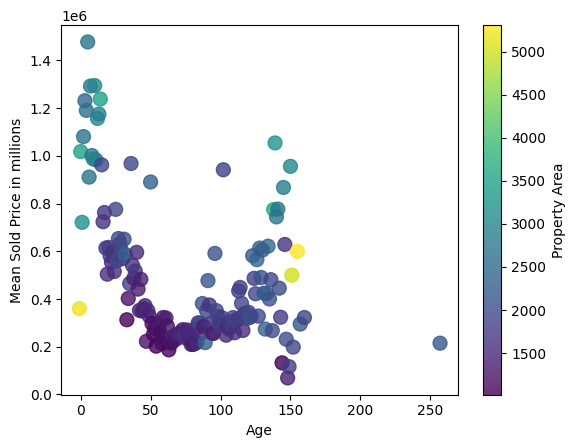

In [370]:
grouped_data = df.groupby("age", as_index=False)[["sold_price", "sqft"]].mean()

plt.scatter(grouped_data["age"], grouped_data["sold_price"], c=grouped_data["sqft"], cmap='viridis', s=100, alpha=0.8)
plt.colorbar(label='Property Area')

plt.xlabel("Age")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This second graph actually doesn't follow the trend I expected it would. There is no discernable correlation between property area and the age. Some newer properties are very large, and so are some that are around 150 years old. There is a single outlier with an age of 250 years, a medium-size area, and a low price.

outlier bounds: -89.0 to 215.0


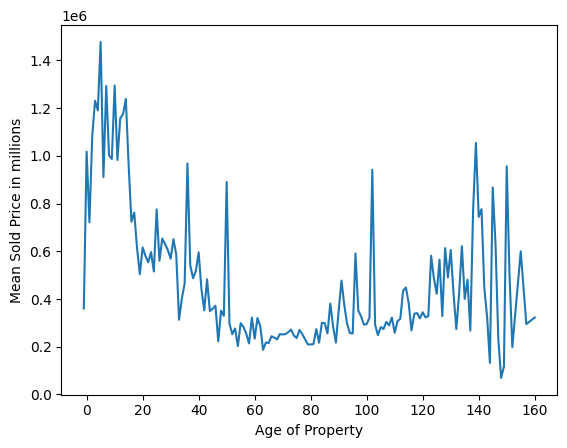

In [371]:
df_age = outlier_calc(df, "age")

grouped_data = df_age.groupby("age", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["age"], grouped_data["sold_price"])

plt.xlabel("Age of Property")
plt.ylabel("Mean Sold Price in millions")
plt.show()

In [372]:
df.columns = df.columns.str.strip()

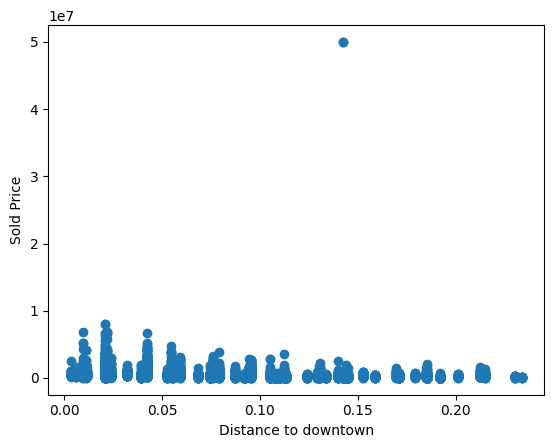

In [373]:
df["dist_to_downtown"] = ((df["latitude"] - 41.8832)**2 + (df["longitude"] + 87.6324)**2) ** 0.5

plt.scatter(df["dist_to_downtown"], df["sold_price"])

plt.xlabel("Distance to downtown")
plt.ylabel("Sold Price")
plt.show()

# 4.Prepare the Data


Apply any data transformations and explain what and why


After looking through the statistics, I've determined the features I'll be including to maximize prediction accuracy and minimize parameter count are number of rooms, property area, age, and geographic location. Although number of rooms and property area seem to follow very similar trends, so I might be able to not use that attribute.

In [468]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['SINGLE_FAMILY', 'CONDOS', 'TOWNHOMES', 'MULTI_FAMILY']])
df['home_style'] = encoder.fit_transform(df[['style']])

In [469]:
df["stories"] = df["stories"].replace(0, 1)

In [472]:
from sklearn.cluster import KMeans

coords = df[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=10, random_state=42)
df['location_cluster'] = kmeans.fit_predict(coords)

df['good_area'] = (df.groupby(['zip_lat', 'zip_long'])['sold_price'].transform('mean') > df['sold_price'].mean()).astype(int)

In [473]:
df.head()

,property_id,formatted_address,zip_code,style,beds,full_baths,half_baths,sqft,list_price,sold_price,...,age,zip,latitude,longitude,baths,numOfRooms,dist_to_downtown,home_style,location_cluster,good_area
0,8818482037,"100 E Bellevue Pl Apt 5F, Chicago, IL, 60611",60611,CONDOS,2.0,2.0,NaN,1400.0,600000.0,585000.0,...,54.0,60611,41.894742,-87.615073,2.5,4.5,0.020819,1.0,1,1
1,8216192504,"4124 N Pontiac Ave, Chicago, IL, 60634",60634,SINGLE_FAMILY,3.0,2.0,NaN,1766.0,365000.0,345000.0,...,77.0,60634,41.946189,-87.806117,2.5,5.5,0.184784,0.0,8,0
2,9705735225,"211 N Harbor Dr Apt 1304, Chicago, IL, 60601",60601,CONDOS,2.0,2.0,NaN,1251.0,990000.0,995000.0,...,3.0,60601,41.885155,-87.621512,2.5,4.5,0.011062,1.0,1,1
3,8018556780,"11656 S Avenue N, Chicago, IL, 60617",60617,SINGLE_FAMILY,4.0,2.0,NaN,1788.0,429000.0,420000.0,...,28.0,60617,41.714417,-87.555761,2.5,6.5,0.185368,0.0,2,0
4,8509659172,"155 N Harbor Dr Apt 1111, Chicago, IL, 60601",60601,CONDOS,2.0,2.0,NaN,1369.0,480000.0,460000.0,...,51.0,60601,41.885155,-87.621512,2.5,4.5,0.011062,1.0,1,0


In [474]:
correlation_matrix = df.drop(columns=["formatted_address", "property_id", "zip_code", "style", "list_price", "zip"]).corr()
correlation_matrix = correlation_matrix["sold_price"].sort_values(ascending=False)
print(correlation_matrix)

sold_price          1.000000
sqft                0.376764
good_area           0.374752
baths               0.304659
full_baths          0.303264
half_baths          0.288441
numOfRooms          0.244448
beds                0.163538
latitude            0.136254
zip_lat             0.132371
days_on_mls         0.062082
stories             0.052820
home_style          0.048583
zip_long            0.045577
longitude           0.043474
location_cluster   -0.079343
age                -0.143690
dist_to_downtown   -0.196783
Name: sold_price, dtype: float64


From this correlation matrix, I can see which features are most closely correlated and then pick a few to start with.

In [475]:
model_df = df[["sold_price", "sqft", "baths", "numOfRooms", "age", "dist_to_downtown", "good_area"]]

for x in model_df.columns:
    model_df = outlier_calc(model_df, x)

print(model_df.info())

outlier bounds: -350000.0 to 1010000.0
outlier bounds: -212.0 to 3084.0
outlier bounds: 0.0 to 4.0
outlier bounds: 0.5 to 8.5
outlier bounds: -80.0 to 208.0
outlier bounds: -0.13099340094279618 to 0.3229092569849201
outlier bounds: 0.0 to 0.0
<class 'pandas.core.frame.DataFrame'>
Index: 6365 entries, 1 to 10426
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold_price        6365 non-null   float64
 1   sqft              6365 non-null   float64
 2   baths             6365 non-null   float64
 3   numOfRooms        6365 non-null   float64
 4   age               6365 non-null   float64
 5   dist_to_downtown  6365 non-null   float64
 6   good_area         6365 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 397.8 KB
None


In [476]:
model_df.to_csv("model_data.csv", index=False)

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


There are 5 models I want to try:
1. Random Forest Regressor
2. Linear Multivariate Regressor
3. Support Vector Regression
4. KNN Regressor
5. Gradient Boosting Regressor

I will use various accuracy measures to determine which model to use for the final product.

In [477]:
model_df.head()

,sold_price,sqft,baths,numOfRooms,age,dist_to_downtown,good_area
1,345000.0,1766.0,2.5,5.5,77.0,0.184784,0
3,420000.0,1788.0,2.5,6.5,28.0,0.185368,0
4,460000.0,1369.0,2.5,4.5,51.0,0.011062,0
5,175000.0,2000.0,2.5,6.5,105.0,0.144992,0
7,206000.0,600.0,1.5,2.5,41.0,0.020819,0


In [478]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [479]:
features = ["sqft", "baths", "numOfRooms", "age", "dist_to_downtown", "good_area"]

X = model_df[features]
y = model_df['sold_price']

In [480]:
# import scaler
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()

In [481]:
# splt into train test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_scaler.fit(X_train)
# scale x
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_scaled = X_scaler.transform(X)

In [482]:
# https://www.geeksforgeeks.org/machine-learning/random-forest-regression-in-python/
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score

def return_stats(model):
    global X_train_scaled, X_test_scaled, y_train, y_test
    
    model.fit(X_train_scaled, y_train)
    
    y_train_pred = model.predict(X_train_scaled)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    print("Train scores")
    print(f"RMSE: {train_rmse}")
    print(f"MAE: {train_mae}")
    print(f"MA%E: {train_mape}")
    print(f"R^2: {train_r2}\n")
    
    y_test_pred = model.predict(X_test_scaled)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("Test scores")
    print(f"RMSE: {test_rmse}")
    print(f"MAE: {test_mae}")
    print(f"MA%E: {test_mape}")
    print(f"R^2: {test_r2}\n")


    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2']

    scores = cross_validate(model, X_train_scaled, y_train, scoring=scoring)
    print("Train scores with cross validation")
    print(f"Mean RMSE: {-1 * scores['test_neg_root_mean_squared_error'].mean()}")
    print(f"Mean MAE: {-1 * scores['test_neg_mean_absolute_error'].mean()}")
    print(f"Mean MA%E: {-1 * scores['test_neg_mean_absolute_percentage_error'].mean()}")
    print(f"Mean R^2: {scores['test_r2'].mean()}\n")

In [483]:
rf = RandomForestRegressor(random_state=42)
return_stats(rf)

Train scores
RMSE: 34514.060562043174
MAE: 24534.103132962922
MA%E: 0.29582821767412437
R^2: 0.927720544974695

Test scores
RMSE: 86680.44877816454
MAE: 62361.35638611955
MA%E: 0.9086476056841682
R^2: 0.5502022690629946

Train scores with cross validation
Mean RMSE: 90061.15904289838
Mean MAE: 66396.20234159564
Mean MA%E: 0.8558699390155435
Mean R^2: 0.505756781596367



This model is performing way better on the train data that test data, indicating overfitting. There is also a bunch of very weird trends that might be coming from any outliers I have. I'll redo some of the preprocessing and see if I can catch anymore outliers.

Update 1:
Switched to using RMSE, MAE, and R^2. Gave me better scores, but the CV MAE and test MAE (which are similar) are still about 160k off of the true values. Scaling helped a little bit. Will go back to preprocessing and feature correlations.

Update 2:
Removed price outliers, and MAE got closer for test and cross-validation, indicating it's probably getting better at predicting with new data. Still 160k off with heavy overfitting though.

Update 3:
I ended up using mean absolute percentage error and looked at that for accuracy. It's very very bad. 

In [484]:
svr = SVR()
return_stats(svr)

Train scores
RMSE: 128509.07366671486
MAE: 104103.04907113363
MA%E: 1.3362070900283096
R^2: -0.002052190811582477

Test scores
RMSE: 129460.88303523029
MAE: 105474.3319429899
MA%E: 2.014122367066492
R^2: -0.003349151719800547

Train scores with cross validation
Mean RMSE: 128531.10889754273
Mean MAE: 104193.6075755828
Mean MA%E: 1.3390056110036561
Mean R^2: -0.004461338220645516



This model is doing very poorly. It's about 160k off on every prediction, and the R^2 values indicate that this model is worse than just guessing the price.

In [485]:
knn = KNeighborsRegressor()
return_stats(knn)

Train scores
RMSE: 83610.97714620108
MAE: 63651.856559308726
MA%E: 0.8101943428000408
R^2: 0.5758208146348347

Test scores
RMSE: 105329.02665228711
MAE: 79304.17391987432
MA%E: 1.515060226530592
R^2: 0.3358424718602355

Train scores with cross validation
Mean RMSE: 105255.97149548827
Mean MAE: 81110.66051543271
Mean MA%E: 1.076417820451979
Mean R^2: 0.32457828947443246



This model has the best train MAE, but it is overfitting quite a bit.

In [486]:
gbr = GradientBoostingRegressor()
return_stats(gbr)

Train scores
RMSE: 88194.1392806304
MAE: 69191.43993822494
MA%E: 0.9313505321576508
R^2: 0.5280432432485683

Test scores
RMSE: 94610.03748223974
MAE: 73169.51100358972
MA%E: 1.6459329686472906
R^2: 0.46414240941732643

Train scores with cross validation
Mean RMSE: 94532.28818353264
Mean MAE: 73079.52753017984
Mean MA%E: 0.986694032159852
Mean R^2: 0.45582400534821427



This model probably has the best performance besides the random forest regressor. It's definitely overfitting much less.

In [215]:
# save base model

import joblib

joblib.dump(rf, './models/base_rf_model.pkl')
joblib.dump(gbr, './models/base_gbr_model.pkl')

['./models/base_gbr_model.pkl']

There is another type of graident boosting model I can use called xgboost. It doesn't use scikit learn but it is apparently very good!

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
        }

num_round = 100

xg = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xg, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [219]:
# ok so model accuracy is not very good lets train some hyper parameters!

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

In [220]:
gbr_model = joblib.load('./models/base_gbr_model.pkl')
rf_model = joblib.load('./models/base_gbr_model.pkl')

In [223]:
# https://www.geeksforgeeks.org/machine-learning/how-to-tune-hyperparameters-in-gradient-boosting-algorithm/
# def parameters to change and random search through them for best random forest model
param_dist = {'learning_rate': np.arange(0.01, 0.2, 0.01), 
              'n_estimators': [100, 200, 300, 400],  
              'max_depth': [3, 5, 7, 9],  
             }

rand_gbr = RandomizedSearchCV(gbr_model, 
                              param_distributions=param_dist, 
                              n_iter=50, 
                              cv=5,
                              random_state=42, 
                              n_jobs=-1)

rand_gbr.fit(X_train, y_train)
print("Best Params for random for GBR:", rand_gbr.best_params_)
print("Best CV Score for random for GBR:", rand_gbr.best_score_)
best_gbr = rand_gbr.best_estimator_
print("Feature Importances for GBR:", best_gbr.feature_importances_)

Best Params for random for GBR: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.02}
Best CV Score for random for GBR: 0.6899137586823434
Feature Importances for GBR: [0.37653637 0.07745752 0.35068232 0.07966525 0.0128301  0.10282845]


In [224]:
joblib.dump(best_gbr, './models/tuned_gbr_model.pkl')

['./models/tuned_gbr_model.pkl']

This model didn't increase a lot with finetuning, which might suggest a need to go back and do some more feature engineering (more interactions probably). It does generalize pretty well though, which is good!

In [225]:
# def parameters to change and random search through them for best random forest model
param_dist = {'n_estimators': [100, 300, 500],
              'max_depth': [None] + list(range(5, 51, 5)), 
              'min_samples_split': randint(2, 20),
              'min_samples_leaf': randint(1, 10),
             }

rand_rf = RandomizedSearchCV(rf_model, 
                             param_distributions = param_dist,
                             cv=5,
                             n_iter=50,
                             random_state=42, 
                             n_jobs=-1)

rand_rf.fit(X_train, y_train)
print("Best Params for random for random forest:", rand_rf.best_params_)
print("Best CV Score for random for random forest:", rand_rf.best_score_)
best_rf = rand_rf.best_estimator_
print("Feature Importances:", best_rf.feature_importances_)

KeyboardInterrupt: 

In [ ]:
joblib.dump(best_rf, './models/tuned_rf_model.pkl')

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [ ]:
# write params as separate

def infrence([]):

    # take input (wasn't sure how data would be formatted)
    input_df = pd.DataFrame([prams], columns=["Age", "Pclass", "Is_female", "FareBin", "SibSp", "Parch"])
    input_df["Is_female"] = 1 if prams[2] == "female" else 0
    input_df["FareBin"] = pd.cut([prams[3]], bins=fare_bins, labels=False, include_lowest=True)[0]
    input_df["Age"] = round(input_df["Age"], -1) / 10
    input_df["Family"] = prams[-2] + prams[-1] + 1
    input_df.drop(columns=["SibSp", "Parch"], inplace=True)
    print(input_df.head())

    # scale
    new_X = input_df
    new_X_scaled = scaler.transform(new_X)

    # make predictions
    ovo_pred = best_ovo.predict(new_X_scaled)
    ovo_probs = best_ovo.predict_proba(new_X_scaled)
    rf_pred = best_rf.predict(new_X)
    rf_probs = best_rf.predict_proba(new_X)

    # print predictions
    print(f"Survived?: {'Yes' if ovo_pred[0] == 1 else 'No'}. Probability of survival: {round(ovo_probs[0][1]*100, 2)}% (based on svm ovo model)")
    print(f"Survived?: {'Yes' if rf_pred[0] == 1 else 'No'}. Probability of survival: {round(rf_probs[0][1]*100, 2)}% (based on random forest model)")

    # return results
    results = {"OvO": [ovo_pred, ovo_probs],
              "RF": [rf_pred, rf_probs]}
    return results 